Targetless Subtraction of Sinusoidal Noise Part 1
=================================================

In this example, we will do a simple regression problem where an unwanted constant frequency is added to the desired output signal as follows

\begin{align}
s(t) &= \sin(2\pi f_s t)\quad \text{true signal we want}\\
n(t) &= A_n \sin(2\pi f_n t + \phi_n)\quad \text{noise we want the network to subtract}\\
d(t) &= s(t) + n(t) \quad \text{the system output is the signal}
\end{align}

The trick with this regression problem is that we only get to see $d(t)$ and $n(t)$ so we don't actually have the target. Even worse, we may have very little information (in the real world) about what $s(t)$ actually looks like so ensuring that the networks are 'well-behaved' is critical. 

We will again use the mean square error as our cost function. Therefore, the network will aim to minimize 

\begin{equation}
J = \sum_i^{N-1} \left(d(t_i) - f[n(t_i)]\right)^2
\end{equation}

where the function on the noise (the 'witness channel') is adjusting the phase and amplitude of the noise until it is able to reduce the MSE as much as possible. NOTE: The lowest possible value of the MSE is not zero, it is 

\begin{equation}
J_{min} = \sum_i^{N-1} s^2(t_i) = \frac{1}{2}
\end{equation}

In [1]:
# do imports
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(3301)
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [2]:
# let's define the signals
dur = 32
sample_rate = 128
true_freq = 13.4
noise_freq = 5.8
noise_phase = np.pi/4
noise_amp = 0.25
t = np.linspace(0, dur, dur*sample_rate)
s = np.sin(2*np.pi*true_freq * t)
n = noise_amp * np.sin(2*np.pi*noise_freq*t + noise_phase)

# when we generate the signal, we will adjust the phase so that the witness to the noise it out of phase.
# this will force the network to learn the phase as well as the amplitude
d = s + noise_amp * np.sin(2*np.pi*noise_freq*t)  # this is the last time that we will reference 's' until the end

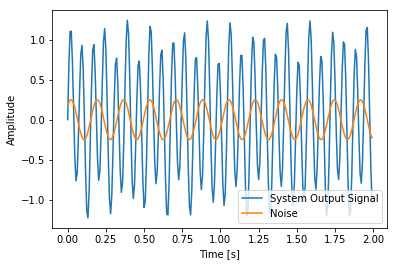

In [3]:
# plot the combined system output and the noise
vis = 2 * sample_rate
plt.plot(t[:vis], d[:vis], label='System Output Signal')
plt.plot(t[:vis], n[:vis], label='Noise')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()
plt.close()

Before we construct the network architecture for this problem, let's think about what we need:

  - The noise is added linearly, so we only need linear activation functions
  - The only adjustable parameters are the phase angle and the amplitude of the noise

This means that a linear feed-forward network with 2 neurons should be enough to capture the dependence of the noise on the system. Usually we will not have this much information, so we have to try to overtrain the network (ensure it *can* converge, and then shrink the parameter space until we have good results and no overtraining)

Let's first split our data into training and testing sets and then create the network for this problem

In [4]:
# make training and testing data
# let's train on 24 seconds and test on 8
x_train = n[:24*sample_rate]
y_train = d[:24*sample_rate]

x_test = n[24*sample_rate:]
y_test = d[24*sample_rate:]

In [5]:
# build the network. We will output 1 data point for each input point. So this network is "one-to-one" or "single-in-single-out"
model = Sequential()
model.add(Dense(2, input_dim=1, activation='linear'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test), batch_size=sample_rate)
y_hat = model.predict(x_test)

W1229 13:33:27.893851 139744860018496 deprecation_wrapper.py:119] From /home/rich.ormiston/deepclean_ve/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1229 13:33:28.121711 139744860018496 deprecation_wrapper.py:119] From /home/rich.ormiston/deepclean_ve/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1229 13:33:28.125149 139744860018496 deprecation_wrapper.py:119] From /home/rich.ormiston/deepclean_ve/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1229 13:33:28.154992 139744860018496 deprecation_wrapper.py:119] From /home/rich.ormiston/deepclean_ve/lib/python2.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.comp

Train on 3072 samples, validate on 1024 samples
Epoch 1/60
3072/3072 [==============================] - 0s 158us/step - loss: 0.6218 - val_loss: 0.6179
Epoch 2/60
3072/3072 [==============================] - 0s 10us/step - loss: 0.6149 - val_loss: 0.6116
Epoch 3/60
3072/3072 [==============================] - 0s 11us/step - loss: 0.6089 - val_loss: 0.6058
Epoch 4/60
3072/3072 [==============================] - 0s 12us/step - loss: 0.6033 - val_loss: 0.6007
Epoch 5/60
3072/3072 [==============================] - 0s 12us/step - loss: 0.5983 - val_loss: 0.5959
Epoch 6/60
3072/3072 [==============================] - 0s 12us/step - loss: 0.5939 - val_loss: 0.5916
Epoch 7/60
3072/3072 [==============================] - 0s 13us/step - loss: 0.5895 - val_loss: 0.5876
Epoch 8/60
3072/3072 [==============================] - 0s 13us/step - loss: 0.5857 - val_loss: 0.5839
Epoch 9/60
3072/3072 [==============================] - 0s 12us/step - loss: 0.5822 - val_loss: 0.5806
Epoch 10/60
3072/3072 [=

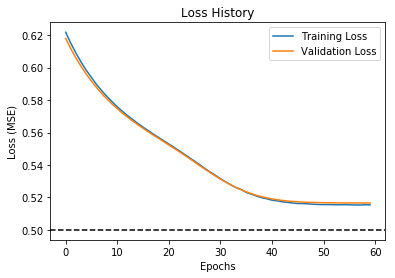

In [6]:
# let's log the loss functions and plot them 
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axhline(0.5, color='black', ls='--')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.show('sine_loss.png')
plt.close()

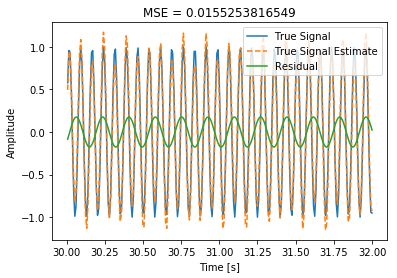

In [7]:
y_hat = y_hat.reshape(y_hat.size)
clean = y_test - y_hat
mse = ((clean[-2*sample_rate:] - s[-2*sample_rate:])**2).mean()
plt.plot(t[30*sample_rate:], s[30*sample_rate:], label='True Signal')
plt.plot(t[30*sample_rate:], clean[-2*sample_rate:], label='True Signal Estimate', ls='--')
plt.plot(t[30*sample_rate:], (clean[-2*sample_rate:]-s[30*sample_rate:]), label='Residual')
plt.legend()
plt.title('MSE = {}'.format(mse))
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()
plt.close()

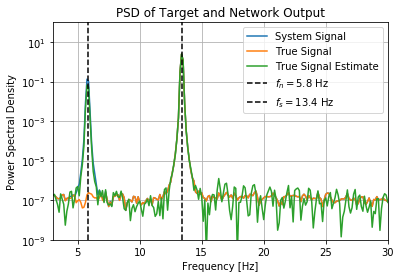

In [8]:
import scipy.signal as sig
noise_floor = 0.01 * np.random.rand(s.size)
freq, clean_psd = sig.welch(clean+noise_floor[:clean.size], fs=sample_rate, nperseg=sample_rate*8)
_, signal_psd = sig.welch(s+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
_, d_psd = sig.welch(d+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
plt.semilogy(freq, d_psd, label='System Signal')
plt.semilogy(freq, signal_psd, label='True Signal')
plt.semilogy(freq, clean_psd, label='True Signal Estimate')
plt.axvline(noise_freq, label='$f_n={}$ Hz'.format(noise_freq), ls='--', color='black')
plt.axvline(true_freq, label='$f_s={}$ Hz'.format(true_freq), ls='--', color='black')
plt.legend(loc='upper right')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.xlim([3, 30])
plt.ylim([1e-9, 1e2])
plt.grid(True)
plt.title('PSD of Target and Network Output')
plt.show()
plt.close()

Hmm, this doesn't look very good. The network has not gotten rid of the noise power at $5.8$ Hz. Why is this? Well, to first give you a hint, let us rerun the network, but this time, we will not make any adjustments to the phase of the input signals

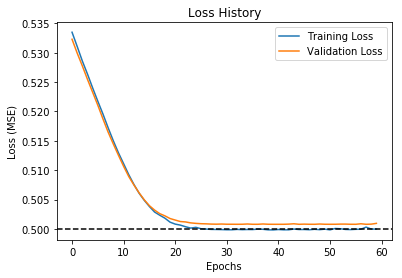

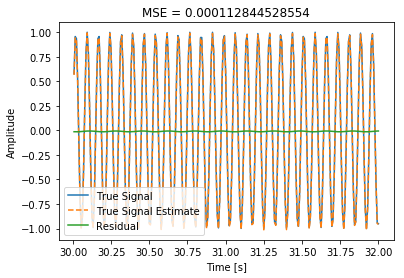

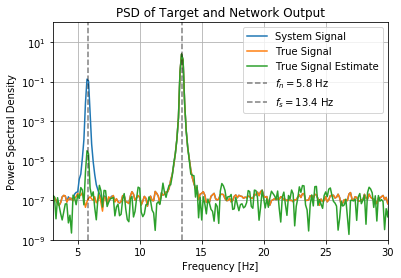

In [10]:
d = s + n

x_train = n[:24*sample_rate]
y_train = d[:24*sample_rate]

x_test = n[24*sample_rate:]
y_test = d[24*sample_rate:]

model = Sequential()
model.add(Dense(2, input_dim=1, activation='linear'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test), batch_size=sample_rate, verbose=0)
y_hat = model.predict(x_test)
y_hat = y_hat.reshape(y_hat.size)

# let's log the loss functions and plot them 
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axhline(0.5, color='black', ls='--')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.show('addition_loss.png')
plt.close()

clean = y_test - y_hat
mse = ((clean[-2*sample_rate:] - s[-2*sample_rate:])**2).mean()
plt.plot(t[30*sample_rate:], s[30*sample_rate:], label='True Signal')
plt.plot(t[30*sample_rate:], clean[-2*sample_rate:], label='True Signal Estimate', ls='--')
plt.plot(t[30*sample_rate:], (clean[-2*sample_rate:]-s[30*sample_rate:]), label='Residual')
plt.legend()
plt.title('MSE = {}'.format(mse))
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()
plt.close()

noise_floor = 0.01 * np.random.rand(s.size)
freq, clean_psd = sig.welch(clean+noise_floor[:clean.size], fs=sample_rate, nperseg=sample_rate*8)
_, signal_psd = sig.welch(s+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
_, d_psd = sig.welch(d+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
plt.semilogy(freq, d_psd, label='System Signal')
plt.semilogy(freq, signal_psd, label='True Signal')
plt.semilogy(freq, clean_psd, label='True Signal Estimate')
plt.axvline(noise_freq, label='$f_n={}$ Hz'.format(noise_freq), ls='--', color='black', alpha=0.5)
plt.axvline(true_freq, label='$f_s={}$ Hz'.format(true_freq), ls='--', color='black', alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.xlim([3, 30])
plt.ylim([1e-9, 1e2])
plt.grid(True)
plt.title('PSD of Target and Network Output')
plt.show()
plt.close()

This is a vast improvement. Evidently, the additional phase gave the network problems. The reason is because of the way we trained, namely, as a "one-to-one" network. When we feed in 1 time-step at a time, there's not a great way to put into context that there has been a phase shift.

We can even explain the final loss value of 0.5166. We know that 0.5 of this should come from the true signal. But what about the last 0.0166? The amplitude of the noise is 1/4 and the average of the sine gives us a 1/2 so we end up with $\left(\frac{1}{2}\right)^2 \left(\frac{1}{4}\right)^2 = \frac{1}{64} = 0.0156$ which is within 1 part in 1000. 

Try adjusting the amplitude of the noise to say 0.5 instead of 0.25 and you should find a residual of about $\frac{1}{2} + \left(\frac{1}{2}\right)^2\left(\frac{1}{2}\right)^2 =\frac{1}{2}+\frac{1}{16} = 0.5625$ (on doing this I get 0.5637)